# Forecasting Indonesia's Youth Unemployment Rate

importing libraries and data

In [380]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [381]:
df = pd.read_csv('../data_ind_youth.csv')

In [382]:
# converting to datetime format
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')
# sorting order chronologically
df = df.sort_values('year_month').reset_index(drop=True)

### exploratory analysis

#### descriptive statistics

In [383]:
# descriptive statistics
df.describe()

,year_month,Unemployment_Rate
count,34,34.000000
mean,2016-05-02 00:00:00,14.615368
min,2008-02-01 00:00:00,11.812190
25%,2012-03-17 12:00:00,13.048628
50%,2016-05-02 00:00:00,14.249481
75%,2020-06-16 12:00:00,15.957687
max,2024-08-01 00:00:00,18.374399
std,NaN,1.826307


### trends and volatility

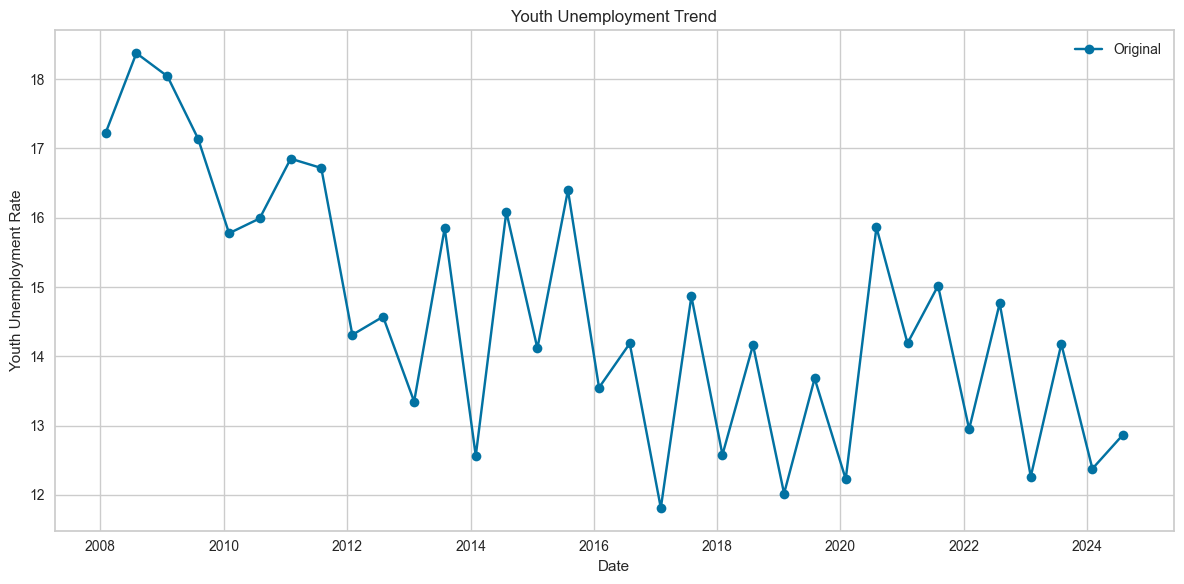

In [384]:
plt.figure(figsize=(12,6))
plt.plot(df['year_month'], df['Unemployment_Rate'], label='Original', marker='o')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [385]:
# adding moving averages (2-period and 4-period) to see smoother trends
df_copy = df.copy()
df_copy['MA_2'] = df_copy['Unemployment_Rate'].rolling(window=2).mean()
df_copy['MA_4'] = df_copy['Unemployment_Rate'].rolling(window=4).mean()

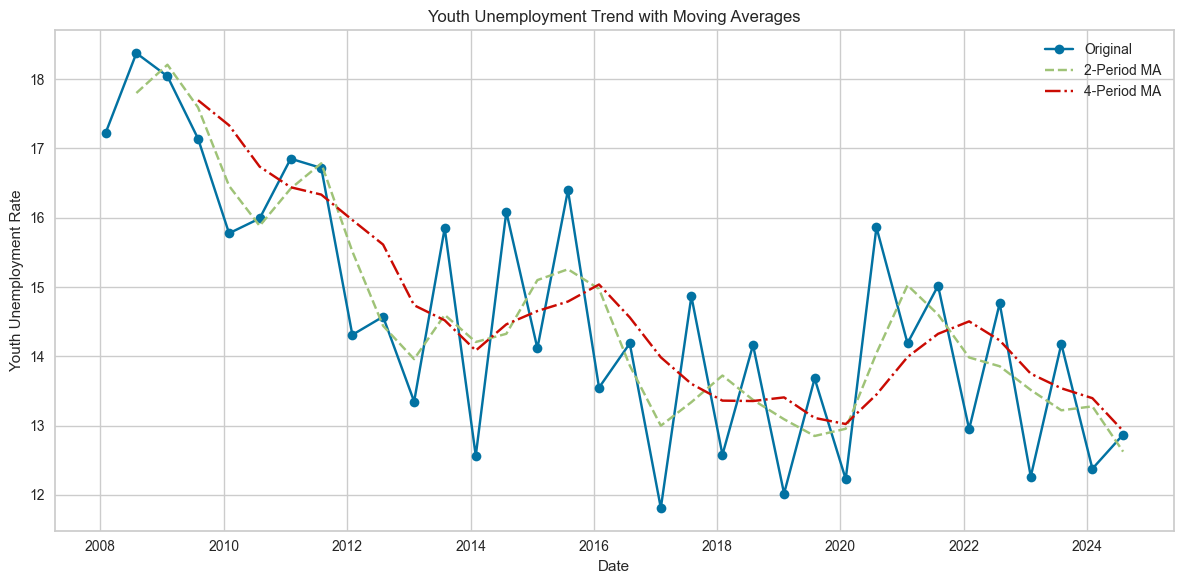

In [386]:
plt.figure(figsize=(12,6))
plt.plot(df_copy['year_month'], df_copy['Unemployment_Rate'], label='Original', marker='o')
plt.plot(df_copy['year_month'], df_copy['MA_2'], label='2-Period MA', linestyle='--')
plt.plot(df_copy['year_month'], df_copy['MA_4'], label='4-Period MA', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Trend with Moving Averages')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### decomposition

In [387]:
from statsmodels.tsa.seasonal import STL

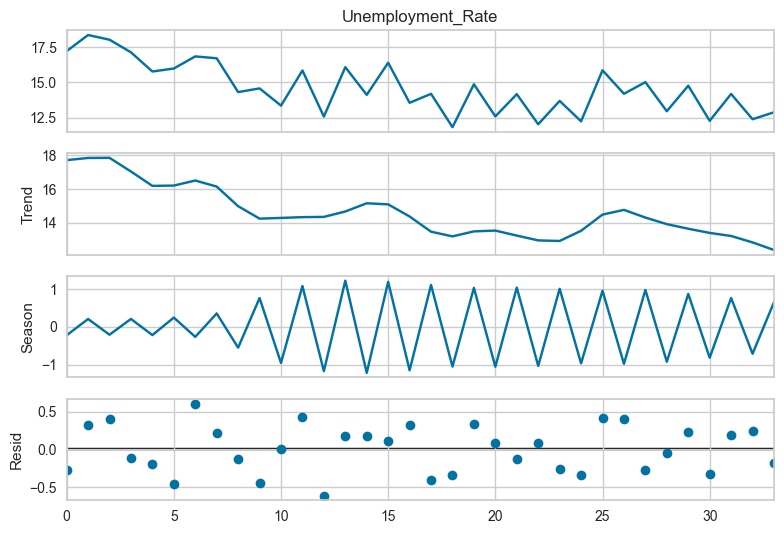

In [388]:
stl = STL(df["Unemployment_Rate"], period=2)  # 2 because it's semiannual
stl_result = stl.fit()
stl_result.plot()
plt.tight_layout()
plt.show()

#### seasonality

In [389]:
df_copy['month'] = df_copy['year_month'].dt.month
df_copy['year'] = df_copy['year_month'].dt.year

<Axes: xlabel='month', ylabel='Unemployment_Rate'>

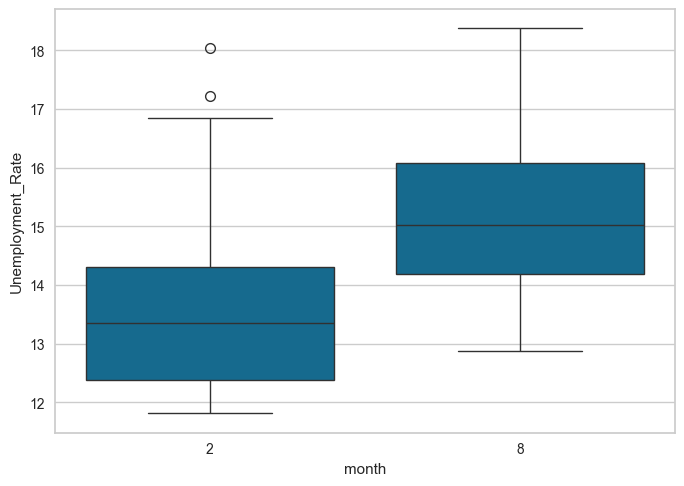

In [390]:
sns.boxplot(x='month', y='Unemployment_Rate', data=df_copy)

In [391]:
pivot_df = df_copy.pivot(index='year', columns='month', values='Unemployment_Rate')
pivot_df.columns = ['Feb', 'Aug']

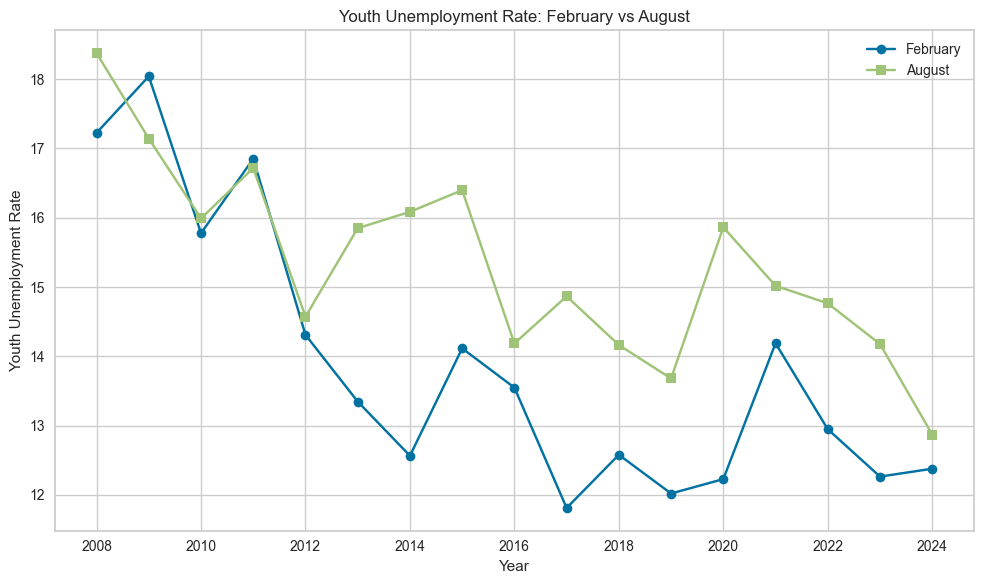

In [392]:
plt.figure(figsize=(10,6))
plt.plot(pivot_df.index, pivot_df['Feb'], label='February', marker='o')
plt.plot(pivot_df.index, pivot_df['Aug'], label='August', marker='s')
plt.xlabel('Year')
plt.ylabel('Youth Unemployment Rate')
plt.title('Youth Unemployment Rate: February vs August')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### stationarity

In [393]:
from statsmodels.tsa.stattools import adfuller

In [394]:
adf_test = adfuller(df['Unemployment_Rate'])
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")

# if p-value > 0.05, series is non-stationary → difference the series

ADF Statistic: -1.9510270770585783
p-value: 0.3084498727851944


differencing

In [395]:
# first difference of the series
df_copy['Unemployment_Diff_1'] = df_copy['Unemployment_Rate'].diff()

# Drop the first row (NaN after differencing)
df_diff = df_copy.dropna(subset=['Unemployment_Diff_1'])

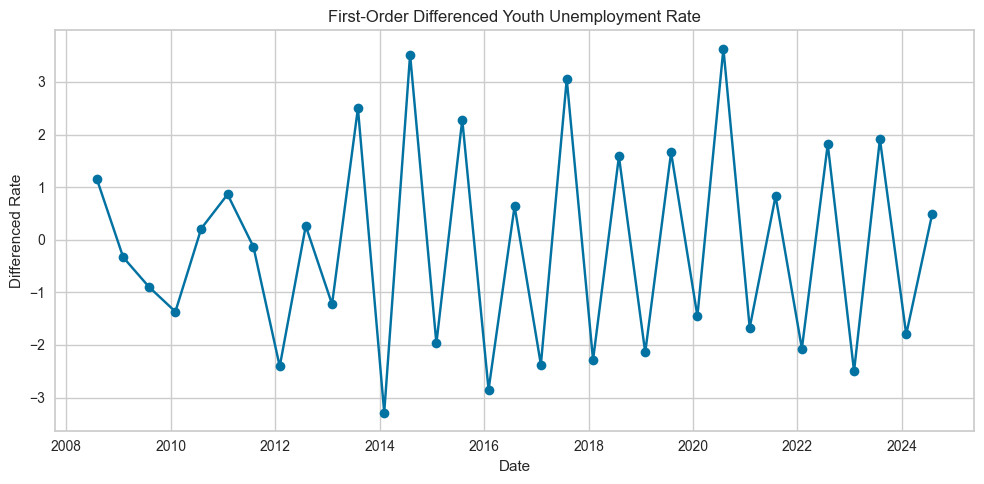

In [396]:
plt.figure(figsize=(10, 5))
plt.plot(df_diff['year_month'], df_diff['Unemployment_Diff_1'], marker='o')
plt.title('First-Order Differenced Youth Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Differenced Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

In [397]:
adf_test_diff_1 = adfuller(df_diff['Unemployment_Diff_1'])
print(f"ADF Statistic: {adf_test_diff_1[0]}")
print(f"p-value: {adf_test_diff_1[1]}")

ADF Statistic: -5.487492241776113
p-value: 2.213091090741889e-06


#### autocorrelation (ACF) & partial autocorrelation (PACF)

In [398]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

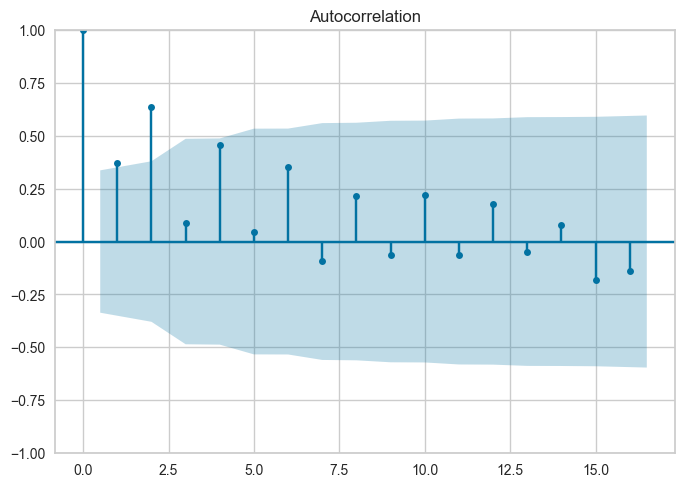

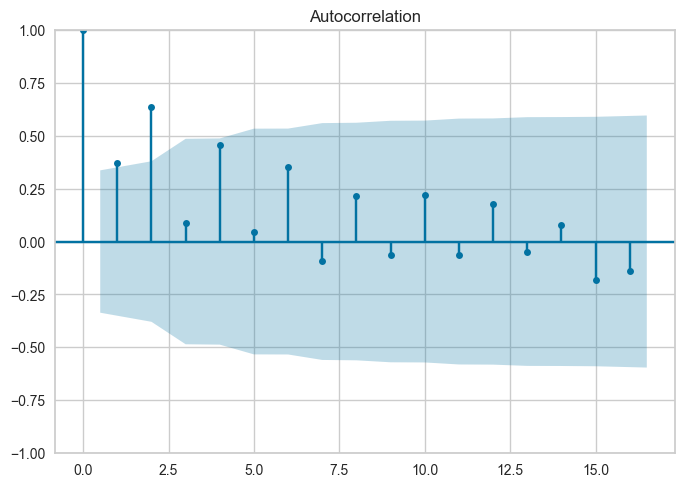

In [399]:
plot_acf(df['Unemployment_Rate'])
# shows pattern, slow decay suggests non-stationarity

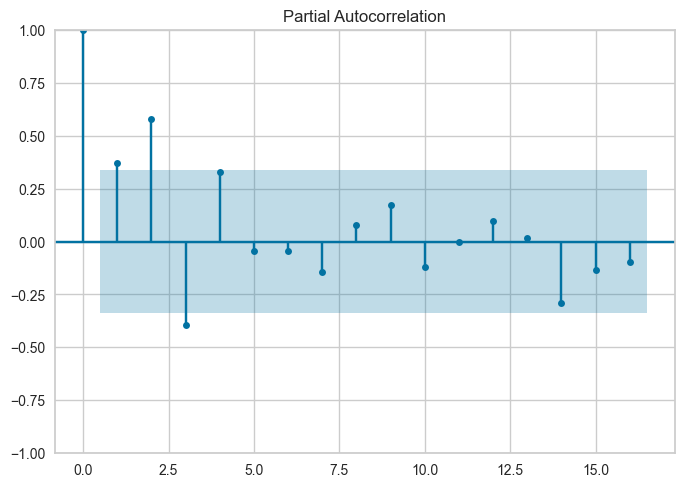

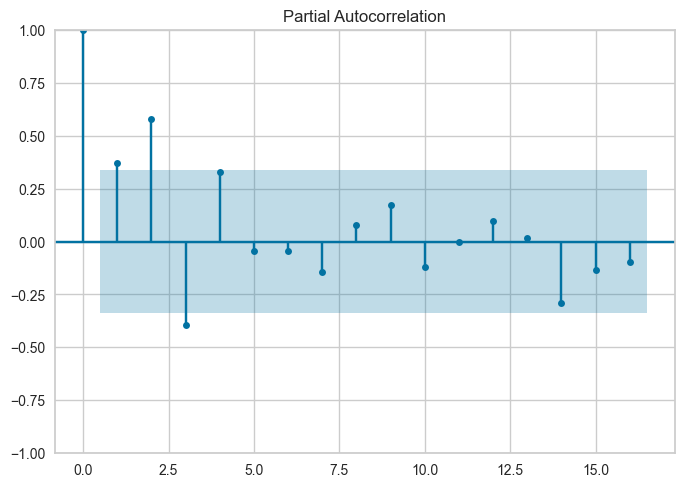

In [400]:
plot_pacf(df['Unemployment_Rate'])
# lags 1, 2, 3, 4 (spikes) are important in modeling the udnerlying data

#### trend smoothness

In [401]:
window_size = 2

df_copy['rolling_mean'] = df_copy['Unemployment_Rate'].rolling(window=window_size).mean()
df_copy['rolling_std'] = df_copy['Unemployment_Rate'].rolling(window=window_size).std()

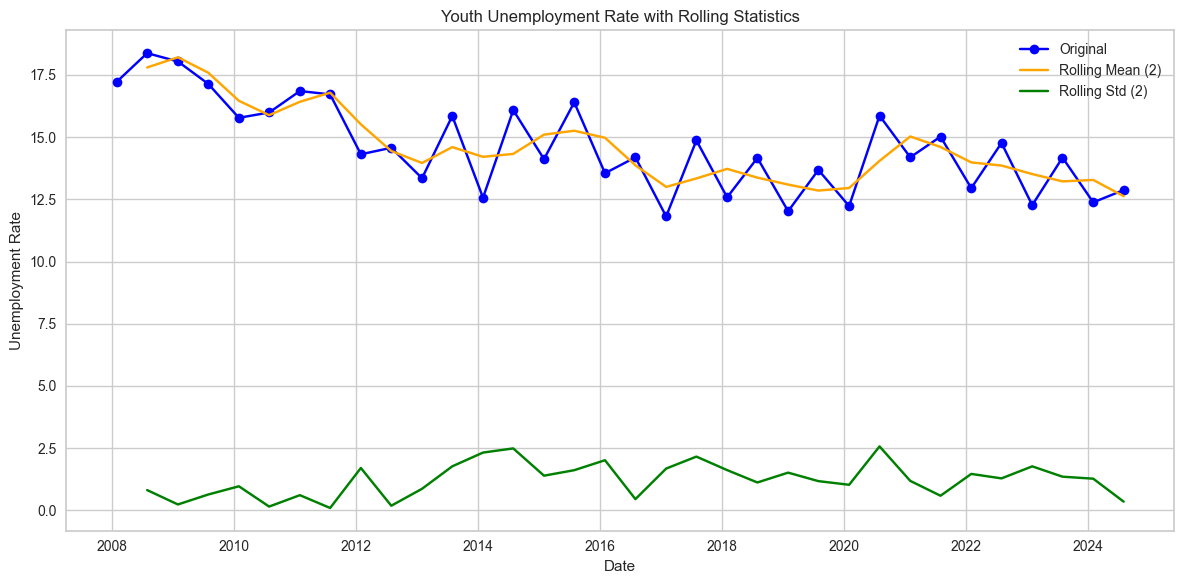

In [402]:
plt.figure(figsize=(12,6))
plt.plot(df_copy['year_month'], df_copy['Unemployment_Rate'], label='Original', color='blue', marker='o')
plt.plot(df_copy['year_month'], df_copy['rolling_mean'], label=f'Rolling Mean ({window_size})', color='orange')
plt.plot(df_copy['year_month'], df_copy['rolling_std'], label=f'Rolling Std ({window_size})', color='green')
plt.title('Youth Unemployment Rate with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [403]:
window_size = 2

df_copy['rolling_mean_diff'] = df_copy['Unemployment_Diff_1'].rolling(window=window_size).mean()
df_copy['rolling_std_diff'] = df_copy['Unemployment_Diff_1'].rolling(window=window_size).std()

df_diff_plot = df_copy.dropna(subset=['rolling_mean_diff', 'rolling_std_diff'])

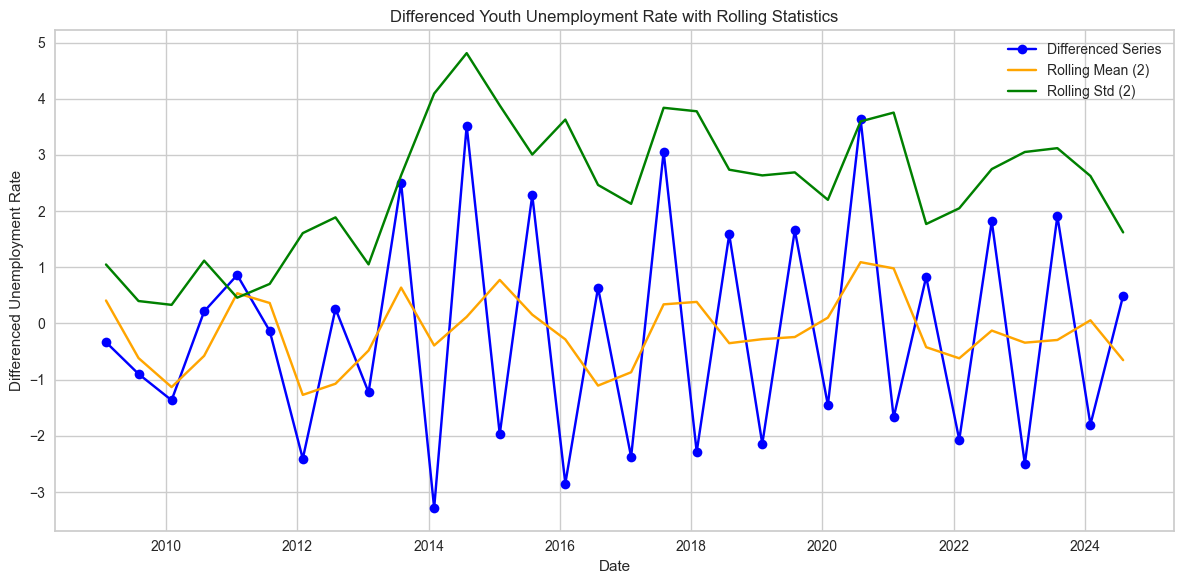

In [404]:
plt.figure(figsize=(12,6))
plt.plot(df_diff_plot['year_month'], df_diff_plot['Unemployment_Diff_1'], label='Differenced Series', color='blue', marker='o')
plt.plot(df_diff_plot['year_month'], df_diff_plot['rolling_mean_diff'], label=f'Rolling Mean ({window_size})', color='orange')
plt.plot(df_diff_plot['year_month'], df_diff_plot['rolling_std_diff'], label=f'Rolling Std ({window_size})', color='green')
plt.title('Differenced Youth Unemployment Rate with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Differenced Unemployment Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### outlier detection

In [405]:
from scipy.stats import zscore

In [406]:
# calculate Z-score for the unemployment rate
df_copy['z_score'] = zscore(df_copy['Unemployment_Rate'])

# set threshold (usually 3 or -3)
threshold = 3

# identify outliers (those where |z_score| > threshold)
outliers = df_copy[abs(df_copy['z_score']) > threshold]

In [407]:
print(outliers[['year_month', 'Unemployment_Rate', 'z_score']])

Empty DataFrame
Columns: [year_month, Unemployment_Rate, z_score]
Index: []


or

In [408]:
Q1 = df_copy['Unemployment_Rate'].quantile(0.25)
Q3 = df_copy['Unemployment_Rate'].quantile(0.75)
IQR = Q3 - Q1

# set outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers_iqr = df_copy[(df_copy['Unemployment_Rate'] < lower_bound) | (df_copy['Unemployment_Rate'] > upper_bound)]

In [409]:
print(outliers_iqr[['year_month', 'Unemployment_Rate']])

Empty DataFrame
Columns: [year_month, Unemployment_Rate]
Index: []


#### distribution

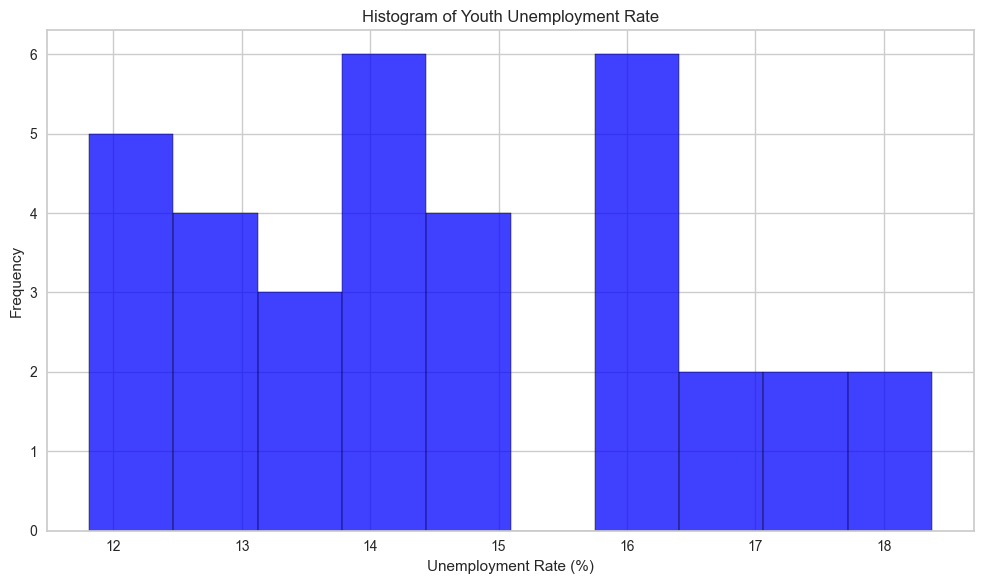

In [410]:
plt.figure(figsize=(10,6))
sns.histplot(df['Unemployment_Rate'], kde=False, bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Youth Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

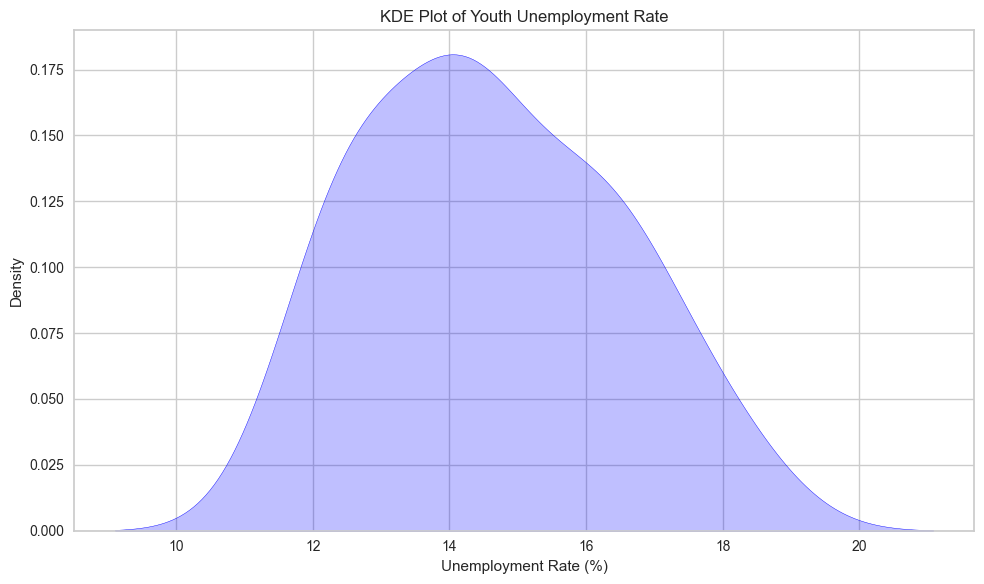

In [411]:
plt.figure(figsize=(10,6))
sns.kdeplot(df['Unemployment_Rate'], color='blue', fill=True)
plt.title('KDE Plot of Youth Unemployment Rate')
plt.xlabel('Unemployment Rate (%)')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

In [412]:
# skewness
df['Unemployment_Rate'].skew()
# 0.2948276004632729 -> slightly positively skewed

0.2948276004632729

### forecasting

general first test with pycaret

In [413]:
df_forecast = df.copy()
df_forecast.set_index('year_month', inplace=True)

df_forecast.index = pd.to_datetime(df_forecast.index)
df_forecast.index = pd.period_range(start=df_forecast.index[0], periods=len(df_forecast), freq='2Q')

In [414]:
from pycaret.time_series import *
import numpy as np

In [415]:
exp = setup(data=df_forecast, target='Unemployment_Rate', fh = 6, session_id = 123)

,Description,Value
0,session_id,123
1,Target,Unemployment_Rate
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(34, 1)"
5,Transformed data shape,"(34, 1)"
6,Transformed train set shape,"(28, 1)"
7,Transformed test set shape,"(6, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [416]:
check_stats()

,Test,Test Name,Data,Property,Setting,Value
0,Summary,Statistics,Transformed,Length,,34.0
1,Summary,Statistics,Transformed,# Missing Values,,0.0
2,Summary,Statistics,Transformed,Mean,,14.615368
3,Summary,Statistics,Transformed,Median,,14.249481
4,Summary,Statistics,Transformed,Standard Deviation,,1.826307
5,Summary,Statistics,Transformed,Variance,,3.335398
6,Summary,Statistics,Transformed,Kurtosis,,-0.857332
7,Summary,Statistics,Transformed,Skewness,,0.294828
8,Summary,Statistics,Transformed,# Distinct Values,,34.0
9,White Noise,Ljung-Box,Transformed,Test Statictic,"{'alpha': 0.05, 'K': 24}",68.190447


In [417]:
best_model = compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.8330,0.9551,1.0920,1.4067,0.0743,0.0779,-0.1589,0.0400
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.8409,0.9835,1.1013,1.4448,0.0746,0.0789,-0.2393,0.0533
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.9436,1.0214,1.2417,1.5066,0.0847,0.0890,-0.3301,0.0900
knn_cds_dt,K Neighbors w/ Cond. Deseasonalize & Detrending,0.9632,1.0380,1.2737,1.5300,0.0869,0.0916,-0.3866,0.1033
theta,Theta Forecaster,0.9769,1.0526,1.2820,1.5464,0.0888,0.0913,-0.4254,0.0167
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,1.0302,1.1336,1.3261,1.6492,0.0910,0.0962,-0.6565,0.0333
exp_smooth,Exponential Smoothing,1.0487,1.1314,1.3759,1.6604,0.0932,0.0997,-0.6452,0.0200
ets,ETS,1.0487,1.1314,1.3759,1.6605,0.0932,0.0997,-0.6452,0.0233
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.0521,1.1315,1.3771,1.6599,0.0938,0.0996,-0.6527,0.0833
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,1.0598,1.1344,1.3861,1.6645,0.0944,0.1003,-0.6612,0.0367


In [418]:
exp.plot_model(plot="diagnostics", fig_kwargs={"height": 800, "width": 1000})

In [419]:
exp.plot_model(
    plot="diff",
    data_kwargs={"lags_list": [[1], [1, 2]], "acf": True, "pacf": True, "periodogram": True},
    fig_kwargs={"height": 800, "width": 1500}
)

In [420]:
exp.plot_model(plot="decomp_stl", fig_kwargs={"height": 500})

In [421]:
exp.plot_model(plot="train_test_split", fig_kwargs={"height": 400, "width": 900})
exp.plot_model(plot="cv", fig_kwargs={"height": 400, "width": 900})

individual models and fine-tuning

In [422]:
# gbr_cds_dt
gbr_cds_dt = exp.create_model("gbr_cds_dt")
y_predict_gbr_cds_dt = exp.predict_model(gbr_cds_dt)
exp.plot_model(estimator=gbr_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9606,1.1173,1.4358,1.8271,0.0943,0.0979,-0.5596
1,2015Q3,0.4294,0.5628,0.5238,0.7833,0.0379,0.0395,0.4310
2,2018Q3,1.1089,1.1851,1.3164,1.6096,0.0907,0.0962,-0.3481
Mean,NaT,0.8330,0.9551,1.0920,1.4067,0.0743,0.0779,-0.1589
SD,NaT,0.2917,0.2787,0.4047,0.4496,0.0258,0.0271,0.4260


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,GradientBoostingRegressor,0.3967,0.4480,0.4574,0.6011,0.0357,0.0346,0.5764


In [423]:
tuned_gbr_cds_dt = exp.tune_model(gbr_cds_dt)
exp.plot_model(estimator=tuned_gbr_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2821,1.3323,1.9164,2.1787,0.1261,0.1335,-1.2175
1,2015Q3,0.7662,0.7894,0.9347,1.0987,0.0698,0.0700,-0.1193
2,2018Q3,1.4889,1.6530,1.7675,2.2449,0.1197,0.1315,-1.6226
Mean,NaT,1.1791,1.2582,1.5395,1.8408,0.1052,0.1116,-0.9865
SD,NaT,0.3039,0.3564,0.4320,0.5254,0.0252,0.0295,0.6351


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.8s finished


In [424]:
print(gbr_cds_dt)
print(tuned_gbr_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=GradientBoostingRegressor(random_state=123), sp=2,
                    window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=GradientBoostingRegressor(random_state=123), sp=2,
                    window_length=2)


In [425]:
exp.plot_model([gbr_cds_dt, tuned_gbr_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [426]:
# ada_cds_dt
ada_cds_dt = exp.create_model("ada_cds_dt")
y_predict_ada_cds_dt = exp.predict_model(ada_cds_dt)
exp.plot_model(estimator=ada_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9629,1.1207,1.4392,1.8327,0.0945,0.0981,-0.5691
1,2015Q3,0.3973,0.4967,0.4847,0.6913,0.0352,0.0365,0.5569
2,2018Q3,1.1625,1.3330,1.3801,1.8104,0.0939,0.1020,-0.7055
Mean,NaT,0.8409,0.9835,1.1013,1.4448,0.0746,0.0789,-0.2393
SD,NaT,0.3241,0.3549,0.4367,0.5329,0.0278,0.0300,0.5657


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,AdaBoostRegressor,0.5393,0.5628,0.6218,0.7551,0.0478,0.0462,0.3314


In [427]:
tuned_ada_cds_dt = exp.tune_model(ada_cds_dt)
exp.plot_model(estimator=tuned_ada_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.9606,1.1173,1.4358,1.8271,0.0943,0.0979,-0.5596
1,2015Q3,0.8596,0.9228,1.0485,1.2843,0.0755,0.0777,-0.5293
2,2018Q3,1.1641,1.2949,1.3819,1.7587,0.0943,0.1017,-0.6096
Mean,NaT,0.9947,1.1117,1.2887,1.6234,0.0880,0.0924,-0.5662
SD,NaT,0.1266,0.1520,0.1713,0.2414,0.0089,0.0105,0.0331


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.3s finished


In [428]:
print(ada_cds_dt)
print(tuned_ada_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=123), sp=2,
                    window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=AdaBoostRegressor(random_state=123), sp=2,
                    window_length=2)


In [429]:
exp.plot_model([ada_cds_dt, tuned_ada_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [430]:
# rf_cds_dt
rf_cds_dt = exp.create_model("rf_cds_dt")
y_predict_rf_cds_dt = exp.predict_model(rf_cds_dt)
exp.plot_model(estimator=rf_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1170,1.2043,1.6695,1.9694,0.1099,0.1148,-0.8119
1,2015Q3,0.6423,0.7194,0.7835,1.0013,0.0569,0.0597,0.0704
2,2018Q3,1.0716,1.1406,1.2721,1.5492,0.0873,0.0925,-0.2489
Mean,NaT,0.9436,1.0214,1.2417,1.5066,0.0847,0.0890,-0.3301
SD,NaT,0.2139,0.2151,0.3624,0.3964,0.0217,0.0226,0.3648


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,RandomForestRegressor,0.3862,0.4621,0.4453,0.6199,0.0348,0.0337,0.5494


In [431]:
tuned_rf_cds_dt = exp.tune_model(rf_cds_dt)
exp.plot_model(estimator=tuned_rf_cds_dt)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.0829,1.2001,1.6186,1.9625,0.1070,0.1113,-0.7992
1,2015Q3,0.8367,0.8105,1.0206,1.1280,0.0737,0.0759,-0.1799
2,2018Q3,1.5176,1.6512,1.8015,2.2425,0.1228,0.1353,-1.6170
Mean,NaT,1.1457,1.2206,1.4802,1.7777,0.1011,0.1075,-0.8654
SD,NaT,0.2815,0.3435,0.3335,0.4734,0.0205,0.0244,0.5886


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.5s finished


In [432]:
print(rf_cds_dt)
print(tuned_rf_cds_dt)

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=RandomForestRegressor(n_jobs=-1, random_state=123),
                    sp=2, window_length=2)
BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [2, 1]},
                                                   n_jobs=1)],
                    regressor=RandomForestRegressor(n_jobs=-1, random_state=123),
                    sp=2, window_length=2)


In [433]:
exp.plot_model([rf_cds_dt, tuned_rf_cds_dt], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [434]:
exp_smooth = exp.create_model("exp_smooth")
y_predict_exp_smooth = exp.predict_model(exp_smooth)
exp.plot_model(estimator=exp_smooth)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2239,1.2739,1.8294,2.0832,0.1197,0.1277,-1.0274
1,2015Q3,0.5009,0.5518,0.6110,0.7680,0.0453,0.0457,0.4530
2,2018Q3,1.4212,1.5684,1.6872,2.1301,0.1145,0.1257,-1.3611
Mean,NaT,1.0487,1.1314,1.3759,1.6604,0.0932,0.0997,-0.6452
SD,NaT,0.3956,0.4271,0.5439,0.6313,0.0339,0.0382,0.7884


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Exponential Smoothing,0.4812,0.5389,0.5549,0.7230,0.0426,0.0411,0.3870


In [435]:
tuned_exp_smooth = exp.tune_model(exp_smooth)
exp.plot_model(estimator=tuned_exp_smooth)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,0.7614,0.7573,1.1381,1.2383,0.0778,0.0778,0.2836
1,2015Q3,0.6842,0.7256,0.8346,1.0099,0.0648,0.0617,0.0543
2,2018Q3,0.8578,0.8789,1.0183,1.1936,0.0708,0.0735,0.2586
Mean,NaT,0.7678,0.7872,0.9970,1.1473,0.0711,0.0710,0.1988
SD,NaT,0.0710,0.0661,0.1248,0.0989,0.0053,0.0068,0.1027


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.3s finished


In [436]:
print(exp_smooth)
print(tuned_exp_smooth)

ExponentialSmoothing(seasonal='mul', sp=2, trend='add')
ExponentialSmoothing(seasonal='add', sp=2, trend='mul', use_boxcox=False)


In [437]:
exp.plot_model([exp_smooth, tuned_exp_smooth], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [438]:
ets = exp.create_model("ets")
y_predict_ets = exp.predict_model(ets)
exp.plot_model(estimator=ets)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.2240,1.2739,1.8294,2.0833,0.1197,0.1277,-1.0275
1,2015Q3,0.5009,0.5518,0.6110,0.7680,0.0453,0.0457,0.4530
2,2018Q3,1.4212,1.5684,1.6872,2.1301,0.1145,0.1257,-1.3612
Mean,NaT,1.0487,1.1314,1.3759,1.6605,0.0932,0.0997,-0.6452
SD,NaT,0.3956,0.4271,0.5439,0.6313,0.0339,0.0382,0.7884


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ETS,0.4546,0.5151,0.5241,0.6910,0.0405,0.0391,0.4401


In [439]:
tuned_ets = exp.tune_model(ets)
exp.plot_model(estimator=tuned_ets)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.1210,1.1409,1.6756,1.8657,0.1105,0.1161,-0.6261
1,2015Q3,0.4383,0.4307,0.5346,0.5994,0.0400,0.0400,0.6669
2,2018Q3,1.2671,1.4233,1.5042,1.9330,0.1024,0.1117,-0.9445
Mean,NaT,0.9421,0.9983,1.2381,1.4660,0.0843,0.0893,-0.3012
SD,NaT,0.3612,0.4176,0.5024,0.6134,0.0315,0.0349,0.6968


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.2s finished


In [440]:
print(ets)
print(tuned_ets)

AutoETS(seasonal='mul', sp=2, trend='add')
AutoETS(error='mul', seasonal='add', sp=2, trend='mul')


In [441]:
exp.plot_model([ets, tuned_ets], data_kwargs={"labels": ["Baseline", "Tuned"]})

In [442]:
arima = exp.create_model("arima")
y_predict_arima = exp.predict_model(arima)
exp.plot_model(estimator=arima)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2012Q3,1.3945,1.5868,2.0844,2.5950,0.1334,0.1485,-2.1459
1,2015Q3,0.9592,0.9314,1.1701,1.2964,0.0876,0.0830,-0.5583
2,2018Q3,1.1744,1.3560,1.3942,1.8416,0.0949,0.1034,-0.7649
Mean,NaT,1.1761,1.2914,1.5496,1.9110,0.1053,0.1116,-1.1563
SD,NaT,0.1777,0.2714,0.3891,0.5324,0.0201,0.0273,0.7048


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,ARIMA,0.6755,0.6801,0.7788,0.9123,0.0613,0.0588,0.0240


In [443]:
print(arima)

ARIMA(seasonal_order=(0, 1, 0, 2))
